## Importing necessary libraries

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings("ignore")

In [0]:
tf.__version__

'2.1.0'

## Mounting Google-Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'DeepLearning/VadaPav/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Loading the data

In [0]:
data_dir = pathlib.Path(base_dir)

In [0]:
# for fn in data_dir.glob('*/*'):
#     im = Image.open(fn)
#     if im.mode != 'RGB': im.convert('RGB').save(fn)

In [0]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAMES

array(['burger', 'vada pav'], dtype='<U8')

In [0]:
for name in list(data_dir.glob('*/*'))[:5]:
  print(name)

/content/gdrive/My Drive/DeepLearning/VadaPav/burger/112_HLY_Lentil_Burger_Horizontal.jpg
/content/gdrive/My Drive/DeepLearning/VadaPav/burger/130_mcdonalds_bigvegants.jpg
/content/gdrive/My Drive/DeepLearning/VadaPav/burger/139_justin_bowers360-Instagram-1642-ig-1729500479829090957_174534531.jpg
/content/gdrive/My Drive/DeepLearning/VadaPav/burger/14_burger.jpg
/content/gdrive/My Drive/DeepLearning/VadaPav/burger/154_350990_hires.jpg


In [0]:
image_count = len(list(data_dir.glob('*/*')))

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True,validation_split=0.2,rotation_range=20)

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [0]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),subset='training',class_mode='binary')

Found 929 images belonging to 2 classes.


In [0]:
valid_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),subset='validation',class_mode='binary')

Found 232 images belonging to 2 classes.


## Data Exploration

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      # plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.title(CLASS_NAMES[1 if label_batch[n]==1 else 0])
      plt.axis('off')

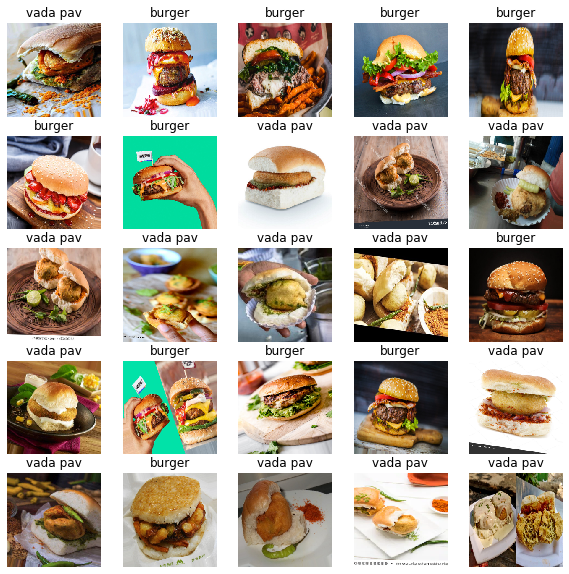

In [0]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)
# label_batch

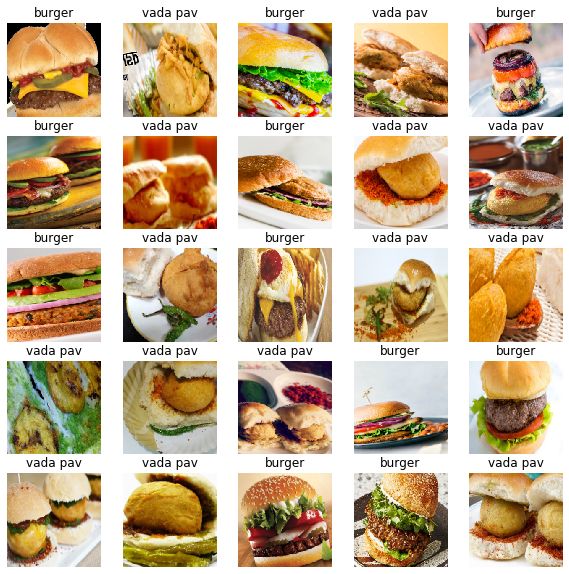

In [0]:
image_batch, label_batch = next(valid_data_gen)
show_batch(image_batch, label_batch)

## Model Building

In [0]:
IMG_SHAPE = image_batch[0].shape
# base_model = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet',input_shape=IMG_SHAPE)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9412608/9406464 [==============================] - 0s 0us/step


In [0]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [0]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [0]:
prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [0]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

## Model Training

In [0]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model.fit(train_data_gen, steps_per_epoch = 929//BATCH_SIZE, epochs=5, 
             validation_data=valid_data_gen, validation_steps=232//BATCH_SIZE)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 29 steps, validate for 7 steps
Epoch 1/5
29/29 [==============================] - 36s 1s/step - loss: 0.5785 - accuracy: 0.7559 - val_loss: 0.3536 - val_accuracy: 0.8482
Epoch 2/5
29/29 [==============================] - 33s 1s/step - loss: 0.1811 - accuracy: 0.9353 - val_loss: 0.2827 - val_accuracy: 0.8750
Epoch 3/5
29/29 [==============================] - 34s 1s/step - loss: 0.1539 - accuracy: 0.9420 - val_loss: 0.5123 - val_accuracy: 0.7946
Epoch 4/5
29/29 [==============================] - 33s 1s/step - loss: 0.1241 - accuracy: 0.9465 - val_loss: 0.2765 - val_accuracy: 0.8973
Epoch 5/5
29/29 [==============================] - 34s 1s/step - loss: 0.1208 - accuracy: 0.9554 - val_loss: 0.2516 - val_accuracy: 0.9152


In [0]:
# model.save_weights(root_dir+'/DeepLearning/SavedModels-VADAPAV/MNET53_12pr.h5')
model.load_weights(root_dir+'/DeepLearning/SavedModels-VADAPAV/MNET53_12pr.h5')

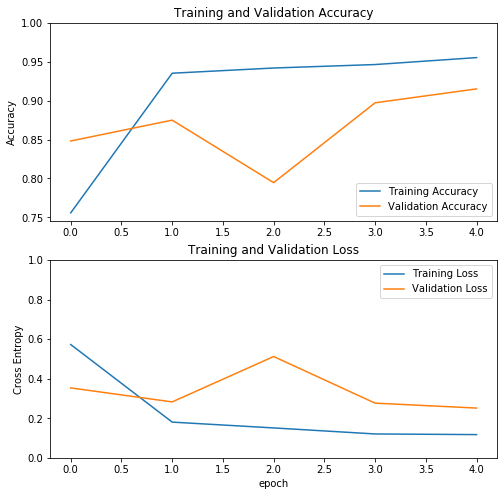

In [0]:
acc = []
val_acc = []
loss = []
val_loss = []

def displayHistory(history):
  global acc,val_acc,loss,val_loss

  acc += history.history['accuracy']
  val_acc += history.history['val_accuracy']

  loss += history.history['loss']
  val_loss += history.history['val_loss']
  
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

displayHistory(history)

## Fine Tuning

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
fine_tune_epochs = 10
total_epochs =  5 + fine_tune_epochs

history_fine = model.fit(train_data_gen, steps_per_epoch = 929//BATCH_SIZE, epochs=total_epochs,initial_epoch=5, 
             validation_data=valid_data_gen, validation_steps=232//BATCH_SIZE)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 29 steps, validate for 7 steps
Epoch 6/15
29/29 [==============================] - 37s 1s/step - loss: 0.0922 - accuracy: 0.9599 - val_loss: 0.1833 - val_accuracy: 0.9509
Epoch 7/15
29/29 [==============================] - 34s 1s/step - loss: 0.0250 - accuracy: 0.9955 - val_loss: 0.1643 - val_accuracy: 0.9420
Epoch 8/15
29/29 [==============================] - 33s 1s/step - loss: 0.0112 - accuracy: 0.9978 - val_loss: 0.1457 - val_accuracy: 0.9464
Epoch 9/15
29/29 [==============================] - 33s 1s/step - loss: 0.0055 - accuracy: 0.9989 - val_loss: 0.1485 - val_accuracy: 0.9464
Epoch 10/15
29/29 [==============================] - 33s 1s/step - loss: 0.0092 - accuracy: 0.9967 - val_loss: 0.1608 - val_accuracy: 0.9420
Epoch 11/15
29/29 [==============================] - 34s 1s/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.1754 - val_accuracy: 0.9464
Epoch 12/15
29/29 [==============================] - 33s 1s/step - 

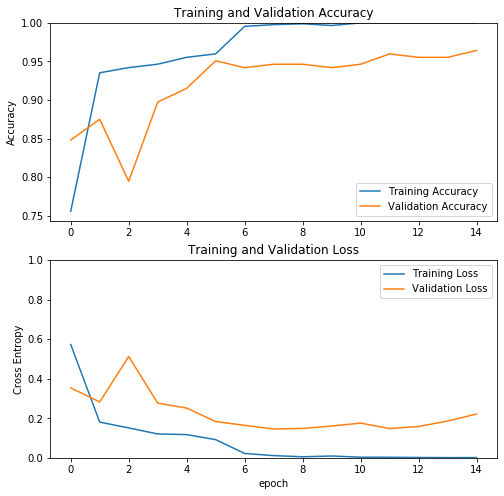

In [0]:
displayHistory(history_fine)

## Model Saving

In [0]:
model.save_weights(root_dir+'/DeepLearning/SavedModels-VADAPAV/MNETunfreeze_9643.h5')

In [0]:
# model.load_weights(root_dir+'/DeepLearning/SavedModels-VADAPAV/MNETunfreeze_9643.h5')